# Predicting Phishing Web Page Using Machine Learning

Phishing is a method of trying to gather personal information using deceptive e-mails and websites.

In this notebook, we will read the data and look at what are the features that can give us information on what are the attributes of a phishing website

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

# FOR MODEL TRAINING 
from sklearn.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier as cuRfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
#Setting the maximum number of columns on display
pd.set_option('display.max_columns', None)
#Setting style-sheet options to 12 by 6 
plt.rcParams['figure.figsize'] = (12,6)

# Loading the data

We will start by loading the provided csv data using pandas read_csv method

In [ ]:
data = pd.read_csv("IS-Phishing-Dataset.csv")

In [ ]:
data

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,labels
0,1,3,1,5,72,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,21,44,0,0,0,0,0.000000,0.250000,1,1,0,0,0,0.000000,0,0,0,0,0,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,0,2,1,0,41,1,0,0,0,0,0,17,16,103,0,1,0,0.000000,0.000000,0,1,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,27,24,0,0,0,0,0.375000,1.000000,1,1,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,22,50,0,0,0,1,1.000000,0.095238,1,1,0,0,0,0.000000,1,0,0,0,1,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,0,0,0,0,2,1,1,0,0,1,0,10,29,0,0,0,0,1.000000,1.000000,0,0,0,1,0,0.000000,1,0,0,0,0,1,0,0,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,3,1,1,50,0,0,0,0,0,0,2,1,0,9,1,0,0,0,0,0,15,10,17,0,0,0,0.096774,0.757143,1,1,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,1,-1,1,0,1,0
9996,9997,2,1,4,59,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,19,33,0,0,0,0,0.161290,0.275862,0,1,0,0,0,0.129032,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0
9997,9998,2,1,4,57,0,0,0,0,0,0,0,0,0,6,1,1,0,0,0,0,16,34,0,0,0,0,0.070423,0.500000,0,1,0,0,0,0.056338,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0
9998,9999,3,1,1,49,0,0,0,0,0,0,1,0,0,3,1,0,0,0,0,0,15,13,13,0,0,0,0.166667,0.428571,0,1,1,0,0,0.000000,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0


# Check for Null Values

array([1, 0], dtype=int32)

In [ ]:
data.isnull().sum()

id                                    0
NumDots                               0
SubdomainLevel                        0
PathLevel                             0
UrlLength                             0
NumDash                               0
NumDashInHostname                     0
AtSymbol                              0
TildeSymbol                           0
NumUnderscore                         0
NumPercent                            0
NumQueryComponents                    0
NumAmpersand                          0
NumHash                               0
NumNumericChars                       0
NoHttps                               0
RandomString                          0
IpAddress                             0
DomainInSubdomains                    0
DomainInPaths                         0
HttpsInHostname                       0
HostnameLength                        0
PathLength                            0
QueryLength                           0
DoubleSlashInPath                     0


# Checking the types of Labels
  The labels consist of 0 and 1 which shows that the website is either a legitimate one or  phishing

In [ ]:
data["labels"].unique()

array([1, 0], dtype=int32)

# Convert data 

In this phase we will convert float64 and int64 data to type 32, by doing this we can save the memory usage and we can prepare the data for using with CuML later for training purpose

As we can see the data has 10k rows and 50 columns including labels

In [ ]:
float_cols = data.select_dtypes('float64').columns
for c in float_cols:
    data[c] = data[c].astype('float32')
    
int_cols = data.select_dtypes('int64').columns
for c in int_cols:
    data[c] = data[c].astype('int32')
    
data.info()

In [ ]:
data.rename(columns={'CLASS_LABEL': 'labels'}, inplace=True)

# View the data

Lets look at random 5 rows from the dataset, it seems like we have mix of ranged data, some column have smaller range compared to others

In [ ]:
data.sample(5)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,labels
4089,4090,5,0,3,67,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,15,45,0,0,1,1,0.941176,0.181818,0,1,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,1,1,0,-1,1
724,725,2,1,5,81,0,0,0,1,0,0,0,0,0,30,0,1,0,0,0,0,23,50,0,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,-1,1,1,1,1,1
8818,8819,4,1,2,36,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,16,13,0,0,0,0,0.000000,0.000000,0,1,0,0,0,0.026316,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0
4773,4774,2,0,6,65,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,12,46,0,0,0,0,0.000000,0.000000,0,1,1,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1
2017,2018,2,0,3,47,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,18,22,0,0,0,0,0.000000,0.000000,0,1,1,0,0,0.000000,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1


In [ ]:
data.tail(10)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,labels
9990,9991,3,1,3,48,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,18,23,0,0,0,0,0.000000,0.400000,0,1,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0
9991,9992,3,1,2,42,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,17,18,0,0,0,0,0.016949,0.183486,0,1,0,1,0,0.042373,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0
9992,9993,3,1,2,49,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,19,23,0,0,0,0,0.142857,0.454545,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0
9993,9994,2,1,1,45,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,17,21,0,0,0,0,0.016129,0.123077,0,1,0,0,0,0.064516,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0
9994,9995,2,1,3,58,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,16,28,6,0,0,0,0.096386,0.144330,0,0,0,0,0,0.000000,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0
9995,9996,3,1,1,50,0,0,0,0,0,0,2,1,0,9,1,0,0,0,0,0,15,10,17,0,0,0,0.096774,0.757143,1,1,0,0,0,0.000000,0,0,0,0,0,0,0,0,1,1,-1,1,0,1,0
9996,9997,2,1,4,59,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,19,33,0,0,0,0,0.161290,0.275862,0,1,0,0,0,0.129032,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0
9997,9998,2,1,4,57,0,0,0,0,0,0,0,0,0,6,1,1,0,0,0,0,16,34,0,0,0,0,0.070423,0.500000,0,1,0,0,0,0.056338,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0
9998,9999,3,1,1,49,0,0,0,0,0,0,1,0,0,3,1,0,0,0,0,0,15,13,13,0,0,0,0.166667,0.428571,0,1,1,0,0,0.000000,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0
9999,10000,3,1,2,52,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,10,35,0,0,0,0,0.089623,0.042553,0,1,0,0,0,0.004717,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0


# Summary Statistics

By using the describe method, we can see some of the columns have high variance and some have smaller variance, this is due to the fact that some of the column have bigger values and bigger ranges

In [ ]:
data.describe()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,labels
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.0,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2.445100,0.586800,3.300300,70.264100,1.818000,0.138900,0.000300,0.013100,0.32320,0.073800,0.458600,0.277200,0.002300,5.810300,0.988800,0.52520,0.017200,0.022200,0.428900,0.0,18.82430,35.564900,8.606500,0.000900,0.109300,0.057100,0.241334,0.392932,0.167200,0.844000,0.248700,0.1018,0.057600,0.136136,0.215300,0.005500,0.014000,0.004900,0.128800,0.339600,0.03220,0.030400,0.956600,0.020200,0.353300,0.793200,0.173400,0.314100,0.500000
std,2886.89568,1.346836,0.751214,1.863241,33.369877,3.106258,0.545744,0.017319,0.113709,1.11466,0.622248,1.344793,1.117356,0.047906,9.617877,0.105241,0.49939,0.130023,0.147341,0.494944,0.0,8.11654,24.588502,24.313053,0.029988,0.368737,0.232045,0.342370,0.387292,0.373173,0.362873,0.432281,0.3024,0.232997,0.312413,0.411051,0.073961,0.117496,0.069832,0.334995,0.473597,0.17654,0.171694,0.248037,0.820036,0.888908,0.521019,0.755771,0.897843,0.500025
min,1.00000,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,4.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2500.75000,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.0,14.00000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,0.000000
50%,5000.50000,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.0,18.00000,30.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.247511,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000
75%,7500.25000,3.000000,1.000000,4.000000,84.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.00000,0.000000,0.000000,1.000000,0.0,22.00000,48.000000,0.000000,0.000000,0.000000,0.000000,0.315874,0.785714,0.000000,1.000000,0.000000,0.0000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000

# Balance/Imbalanced Data

The data is balanced for non-phising and phising label

<AxesSubplot:>

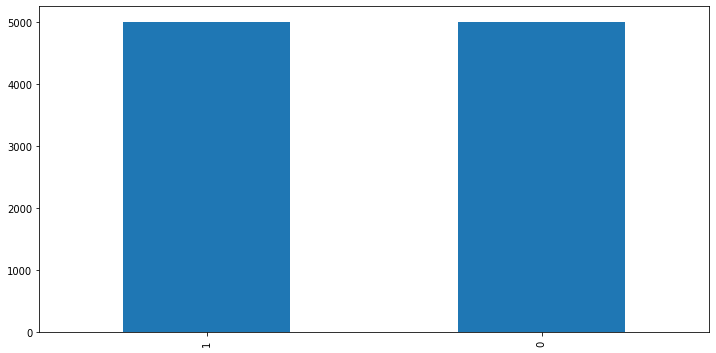

In [ ]:
data['labels'].value_counts().plot(kind='bar')

# Spearman Correlation

By looking the spearman correlation, we can find which features are linearly correlated in terms of predicting if a site is phising or not

In [ ]:
def corr_heatmap(data, idx_s, idx_e):
    y = data['labels']
    temp = data.iloc[:, idx_s:idx_e]
    if 'id' in temp.columns:
        del temp['id']
    temp['labels'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()
  

# First 10 columns

By looking at the first 10 columns against labels, we can concluded that non of the features have strong correlation with the labels, however, NumDash has some significant negative effect towards the labels, which could mean if there is less number of dash then it is more likely to be phising site

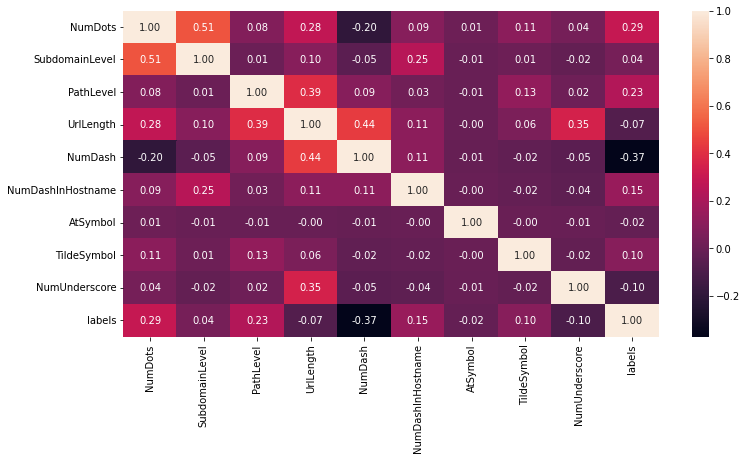

In [ ]:
corr_heatmap(data, 0, 10)

# Columns 10 to 20

There are no strong or even medium level strength correlation features with labels

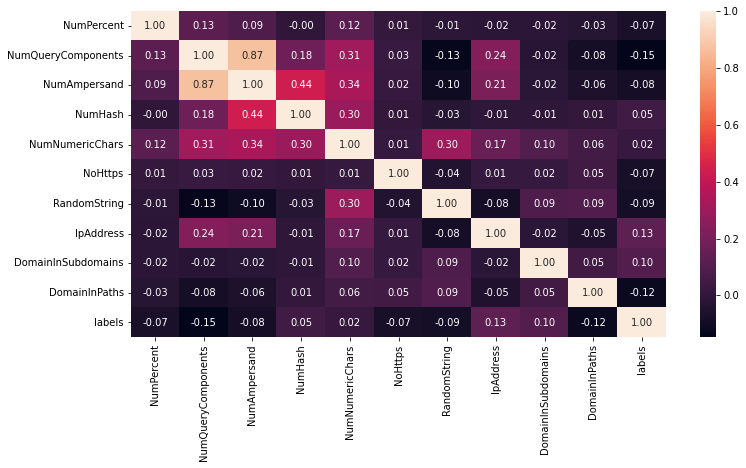

In [ ]:
corr_heatmap(data, 10, 20)

# Columns 20 to 30

Still no strong correlation feature

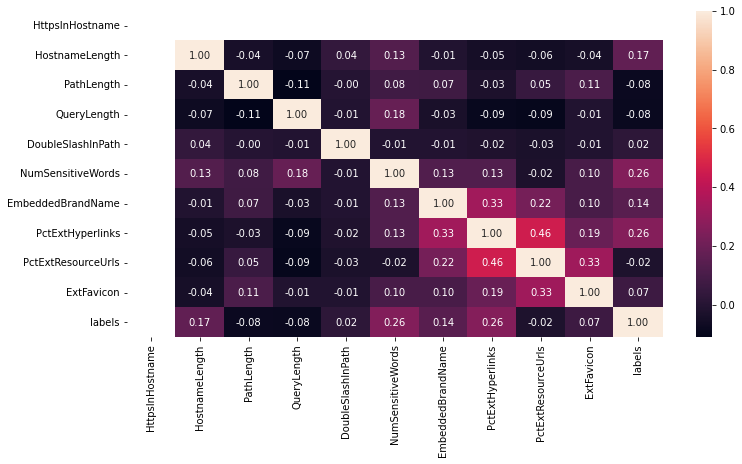

In [ ]:
corr_heatmap(data, 20, 30)

# Columns 30 to 40

Well here we have a few features that are linearly correlated to our dep variable

* InsecureForms shows that as the value is higher so the probability of being a phising site
* PctNullSelfRedirectHyperlinks shows the same positive correlation as InsecureForms
* FequentDomainNameMismatch shows that it has medium linear correlation in positive direction
* SubmitInfoToEmail seems to indicate that sites that ask users to submit their details to emails seems to be more high probability for phising

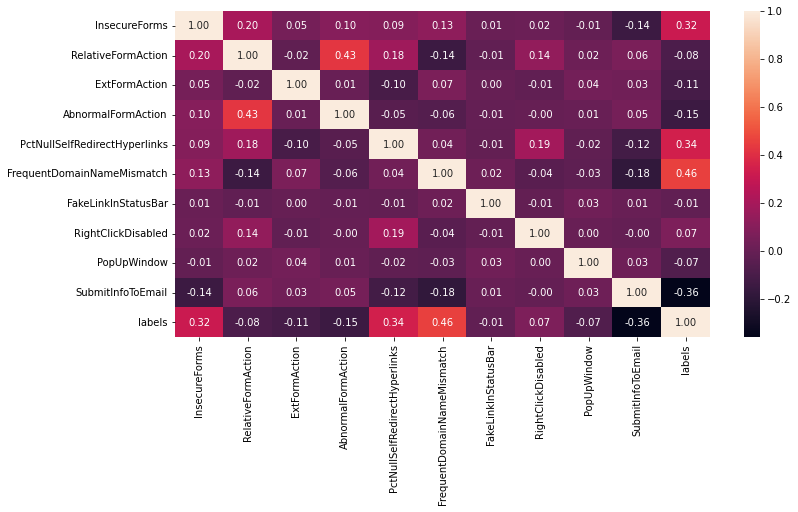

In [ ]:
corr_heatmap(data, 30, 40)

# Columns 40 to 50

The only column in this group that has some correlation with labels is PctExtNullSelfRedirectHyperlinksRT and it has negative effect towards labels which could mean that when the number of percent of null self redirect hyperlinks occur hence the probabiliy of phising increases

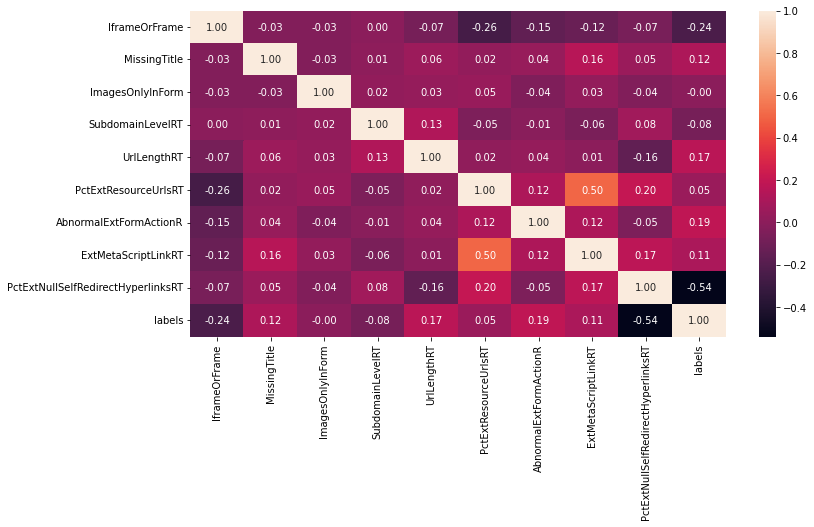

In [ ]:
corr_heatmap(data, 40, 50)

# Mutual Info

  We will use mutual info classifier to find non linear and linear correlation betweem the features and labels.
  
  Mutual information (MI) [1] between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
#Drop the target label and id column from the X variable
X = data.drop(['id', 'labels'], axis=1)
#Put the target variable in Y
y = data['labels']

In [ ]:
discrete_features = X.dtypes == int

Here we process the scores and we can see that now mutual info is showing a bit different list from spearman corr

In [ ]:
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

PctExtHyperlinks                      0.468248
PctExtResourceUrls                    0.296536
PctNullSelfRedirectHyperlinks         0.237547
PctExtNullSelfRedirectHyperlinksRT    0.215860
NumNumericChars                       0.133155
ExtMetaScriptLinkRT                   0.118149
FrequentDomainNameMismatch            0.117121
NumDash                               0.113625
SubmitInfoToEmail                     0.080815
PathLevel                             0.069629
NumDots                               0.062959
QueryLength                           0.052171
InsecureForms                         0.051231
PathLength                            0.050756
UrlLength                             0.041710
NumSensitiveWords                     0.037699
PctExtResourceUrlsRT                  0.032573
NumQueryComponents                    0.032520
IframeOrFrame                         0.028339
HostnameLength                        0.017904
NumPercent                            0.017800
AbnormalExtFo

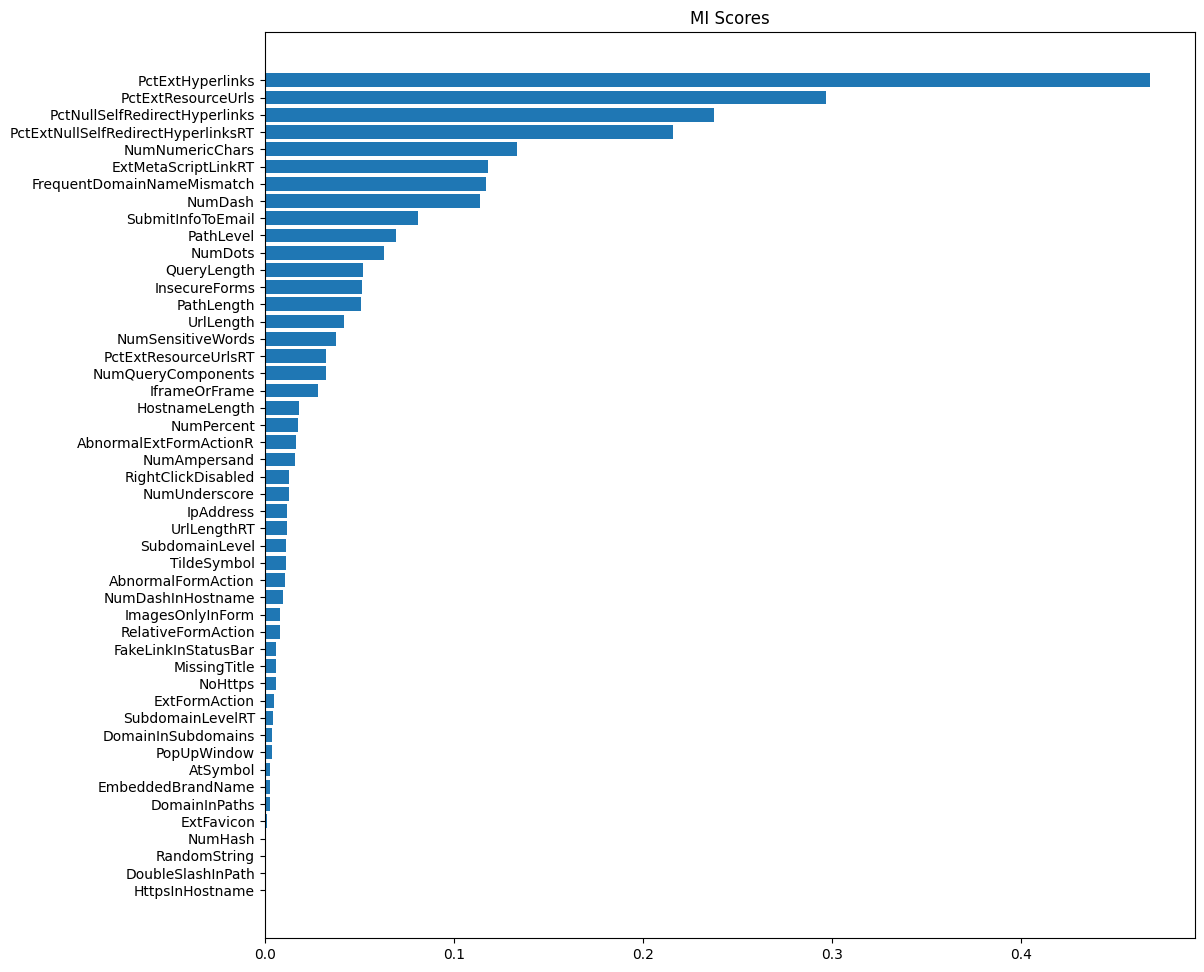

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)  
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("MI Scores")
    
plt.figure(dpi=100, figsize=(12,12))
plot_mi_scores(mi_scores)

# SELECT K-BEST FEATURES
  Select the top K features on the basis of MI

In [ ]:
#Train test split to avoid overfitting.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [ ]:
#For now , we will select top 9 features.
sel_nine_cols=SelectKBest(mutual_info_classif,k=9)
sel_nine_cols.fit(X_train.fillna(0),y_train)
X_train.columns[sel_nine_cols.get_support()]

Index(['NumDash', 'NumNumericChars', 'PctExtHyperlinks', 'PctExtResourceUrls',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'SubmitInfoToEmail', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperlinksRT'],
      dtype='object')

# Prediction

We will first use logistic regression as for baseline, then try to beat the baseline using random forest classifer

Our evaluation metrics will be accuracy, precision, recall and f1 score

Below we import all the required modules

# Train logistic models

This method is to perform a repetative training process using logistic regression model, the purpose for this is to find the optimal number of features that can be used to find the best fitted model without adjusting much of the hyperparameters, hence the idea here is to go with Data-Centric training, basically the method takes number of top N features to be used for training the model and all the evaluation metrics are returned for evaluation purpose

In [ ]:
def train_logistic(data, top_n):
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = data[top_n_features]
    y = data['labels']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy

Here the loop will be starting from 20 as we will start training with top 20 features up to all 50 features to find optimal number of features needed for this problem

In [ ]:
arr = []
for i in range(20,51,1):
    precision, recall, f1, accuracy = train_logistic(data, i)
    print("Performance for Logistic Model with Top {} features is precision : {}, recall : {}, f1 score : {}, accuracy : {}".format(i, precision, recall, f1, accuracy))
    arr.append([i, precision, recall, f1, accuracy])

Performance for Logistic Model with Top 20 features is precision : 0.9021956087824351, recall : 0.932920536635707, f1 score : 0.9173008625063418, accuracy : 0.9185
Performance for Logistic Model with Top 21 features is precision : 0.9182692307692307, recall : 0.9427443237907206, f1 score : 0.9303458353628835, accuracy : 0.9285
Performance for Logistic Model with Top 22 features is precision : 0.9286422200198216, recall : 0.9379379379379379, f1 score : 0.9332669322709163, accuracy : 0.933
Performance for Logistic Model with Top 23 features is precision : 0.9079457364341085, recall : 0.9464646464646465, f1 score : 0.9268051434223541, accuracy : 0.926
Performance for Logistic Model with Top 24 features is precision : 0.9102691924227319, recall : 0.9240890688259109, f1 score : 0.9171270718232045, accuracy : 0.9175
Performance for Logistic Model with Top 25 features is precision : 0.9284294234592445, recall : 0.934934934934935, f1 score : 0.9316708229426434, accuracy : 0.9315
Performance fo

In [ ]:
df = pd.DataFrame(arr, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])
df

,num_of_features,precision,recall,f1_score,accuracy
0,20,0.902196,0.932921,0.917301,0.9185
1,21,0.918269,0.942744,0.930346,0.9285
2,22,0.928642,0.937938,0.933267,0.9330
3,23,0.907946,0.946465,0.926805,0.9260
4,24,0.910269,0.924089,0.917127,0.9175
5,25,0.928429,0.934935,0.931671,0.9315
6,26,0.916000,0.940452,0.928065,0.9290
7,27,0.934077,0.937882,0.935976,0.9370
8,28,0.931818,0.933663,0.932740,0.9320
9,29,0.910048,0.936024,0.922853,0.9205


# Visualize Logistic Reg Performance

As we can see, the model had ups and downs during the training as more number of features were added, as our target is to maximize all the metrics we have to find the number of features that gives us the best of all metrics, from the figure below, we can see that recall is constantly performing good but our model tend to have problem with precision score, hence to choose the best N of features, we have to pick the area where all the metrics are performing and based on the figure I would say its around 39 features

<AxesSubplot:xlabel='num_of_features', ylabel='precision'>

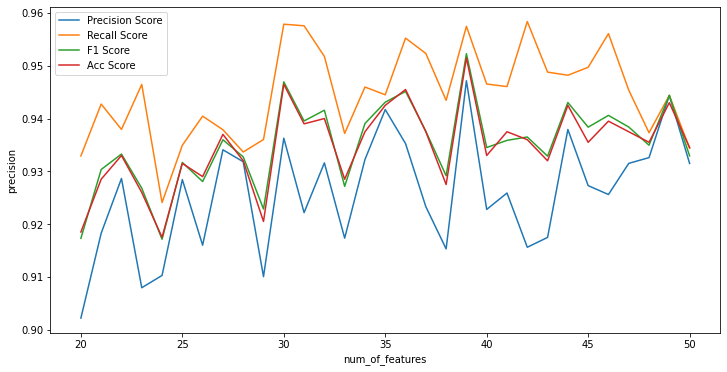

In [ ]:
sns.lineplot(x='num_of_features', y='precision', data=df, label='Precision Score')
sns.lineplot(x='num_of_features', y='recall', data=df, label='Recall Score')
sns.lineplot(x='num_of_features', y='f1_score', data=df, label='F1 Score')
sns.lineplot(x='num_of_features', y='accuracy', data=df, label='Acc Score')

# Training Random Forest Classifier 

It is the same method as logistic reg, the only diff is that we are now using random forest classifier for training and trying to beat the logistic baseline

In [ ]:
def train_rfc(data, top_n):
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = data[top_n_features]
    y = data['labels']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    rfc = cuRfc(n_estimators=500, 
                split_criterion=1,  
                max_depth=32, 
                max_leaves=-1,
                max_features=1.0,
                n_bins=128)
    
    rfc.fit(X_train, y_train)
    
    y_pred = rfc.predict(X_test, predict_model='CPU')
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy

In [ ]:
arr = []
for i in range(20,51,1):
    precision, recall, f1, accuracy = train_rfc(data, i)
    print("Performance for RFC Model with Top {} features is precision : {}, recall : {}, f1 score : {}, accuracy : {}".format(i, precision, recall, f1, accuracy))
    arr.append([i, precision, recall, f1, accuracy])

/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 20 features is precision : 0.9754420432220039, recall : 0.976401179941003, f1 score : 0.9759213759213758, accuracy : 0.9755


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 21 features is precision : 0.9791459781529295, recall : 0.981094527363184, f1 score : 0.9801192842942346, accuracy : 0.98


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 22 features is precision : 0.9699612403100775, recall : 0.9756335282651072, f1 score : 0.9727891156462585, accuracy : 0.972


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 23 features is precision : 0.9702675916749257, recall : 0.9760717846460618, f1 score : 0.9731610337972166, accuracy : 0.973


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 24 features is precision : 0.9742120343839542, recall : 0.9864603481624759, f1 score : 0.9802979336857282, accuracy : 0.9795


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 25 features is precision : 0.9788092835519677, recall : 0.980788675429727, f1 score : 0.9797979797979798, accuracy : 0.98


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 26 features is precision : 0.9803921568627451, recall : 0.9784735812133072, f1 score : 0.9794319294809011, accuracy : 0.979


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 27 features is precision : 0.9743336623889437, recall : 0.9830677290836654, f1 score : 0.9786812097174021, accuracy : 0.9785


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 28 features is precision : 0.97997997997998, recall : 0.97997997997998, f1 score : 0.97997997997998, accuracy : 0.98


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 29 features is precision : 0.9777327935222672, recall : 0.982706002034588, f1 score : 0.9802130898021308, accuracy : 0.9805


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 30 features is precision : 0.9767911200807265, recall : 0.9777777777777777, f1 score : 0.9772841998990408, accuracy : 0.9775


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 31 features is precision : 0.9644970414201184, recall : 0.9858870967741935, f1 score : 0.9750747756729811, accuracy : 0.975


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 32 features is precision : 0.9810326659641728, recall : 0.986228813559322, f1 score : 0.9836238774432118, accuracy : 0.9845


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 33 features is precision : 0.9773622047244095, recall : 0.9812252964426877, f1 score : 0.9792899408284024, accuracy : 0.979


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 34 features is precision : 0.9803343166175025, recall : 0.9812992125984252, f1 score : 0.9808165272995574, accuracy : 0.9805


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 35 features is precision : 0.9778672032193159, recall : 0.9858012170385395, f1 score : 0.9818181818181818, accuracy : 0.982


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 36 features is precision : 0.9794871794871794, recall : 0.9784836065573771, f1 score : 0.9789851358277807, accuracy : 0.9795


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 37 features is precision : 0.9841112214498511, recall : 0.97252208047105, f1 score : 0.9782823297137215, accuracy : 0.978


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 38 features is precision : 0.9771371769383698, recall : 0.9859578736208626, f1 score : 0.9815277084373439, accuracy : 0.9815


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 39 features is precision : 0.9729458917835672, recall : 0.9847870182555781, f1 score : 0.9788306451612904, accuracy : 0.979


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 40 features is precision : 0.9803312629399586, recall : 0.9833852544132918, f1 score : 0.9818558838776569, accuracy : 0.9825


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 41 features is precision : 0.979, recall : 0.9809619238476954, f1 score : 0.97997997997998, accuracy : 0.98


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 42 features is precision : 0.9827586206896551, recall : 0.9846449136276392, f1 score : 0.9837008628954937, accuracy : 0.983


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 43 features is precision : 0.9747081712062257, recall : 0.987192118226601, f1 score : 0.9809104258443466, accuracy : 0.9805


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 44 features is precision : 0.9749518304431599, recall : 0.9844357976653697, f1 score : 0.9796708615682479, accuracy : 0.979


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 45 features is precision : 0.974180734856008, recall : 0.9839518555667001, f1 score : 0.9790419161676647, accuracy : 0.979


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 46 features is precision : 0.9788257940327237, recall : 0.9835589941972921, f1 score : 0.9811866859623734, accuracy : 0.9805


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 47 features is precision : 0.97568093385214, recall : 0.9862340216322517, f1 score : 0.9809290953545232, accuracy : 0.9805


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 48 features is precision : 0.9702085402184707, recall : 0.9799398194583752, f1 score : 0.9750499001996008, accuracy : 0.975


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 49 features is precision : 0.9842829076620825, recall : 0.9794721407624634, f1 score : 0.9818716315531603, accuracy : 0.9815


/opt/conda/lib/python3.7/site-packages/cuml/common/memory_utils.py:56: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  return func(*args, **kwargs)


Performance for RFC Model with Top 50 features is precision : 0.9710144927536232, recall : 0.9804878048780488, f1 score : 0.9757281553398058, accuracy : 0.975


In [ ]:
df = pd.DataFrame(arr, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])
df.head()

,num_of_features,precision,recall,f1_score,accuracy
0,20,0.975442,0.976401,0.975921,0.9755
1,21,0.979146,0.981095,0.980119,0.9800
2,22,0.969961,0.975634,0.972789,0.9720
3,23,0.970268,0.976072,0.973161,0.9730
4,24,0.974212,0.986460,0.980298,0.9795


# Visualize Random Forest Performance

Our goal is to beat logistic regression baseline which is

* accuracy = 0.947162
* precision = 0.957468
* recall = 0.952287
* f1_score = 0.9515

So by visualizing the figure below, we can conclude that the best number of features for this model would be 32, one less than logistic regression, the reason why I chose 32 is because that is the number of features that allowed the model to perform the best across all the evaluation metric

<AxesSubplot:xlabel='num_of_features', ylabel='precision'>

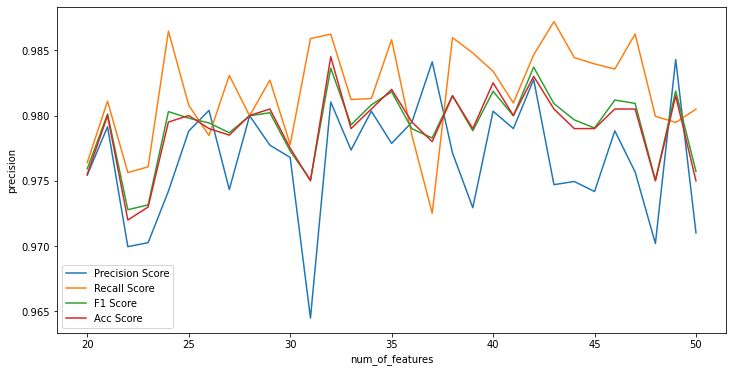

In [ ]:
sns.lineplot(x='num_of_features', y='precision', data=df, label='Precision Score')
sns.lineplot(x='num_of_features', y='recall', data=df, label='Recall Score')
sns.lineplot(x='num_of_features', y='f1_score', data=df, label='F1 Score')
sns.lineplot(x='num_of_features', y='accuracy', data=df, label='Acc Score')

# Final Random Forest Model

Lets train the final random forest model based on the optimal N number of features

In [ ]:
top_n_features = mi_scores.sort_values(ascending=False).head(32).index.tolist()
X = data[top_n_features]
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

rfc = cuRfc(n_estimators=500, 
            split_criterion=1,  
            max_depth=32, 
            max_leaves=-1,
            max_features=1.0,
            n_bins=128)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test, predict_model='CPU')

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Performance for RFC Model with Top {} features is precision : {}, recall : {}, f1 score : {}, accuracy : {}".format(27, precision, recall, f1, accuracy))

Performance for RFC Model with Top 27 features is precision : 0.9771371769383698, recall : 0.9820179820179821, f1 score : 0.979571499750872, accuracy : 0.9795


# Performance

The model is now capable of predicting at up to 98% accuracy and also precision and recall, this shows the model has high confidence in predicting phishing or non-phishing site

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       999
           1       0.98      0.98      0.98      1001

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

